## Imports


In [1]:
import pandas as pd
import numpy as np
import seaborn as sn  
from matplotlib import pyplot as plt
#%matplotlib notebook

from datetime import datetime as dt, timedelta
from pandas_datareader import data as pdr

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Constants

In [0]:
# Figsize
BIG = (20,10)
MEDIUM = (15, 8)
SMALL = (7,5)

#



# Load Shares

In [0]:
def load_share(ticker, start, end):
    
    share = pdr.DataReader(ticker, 'yahoo', start, end)
    
    return share

def load_shares(tickers, start, end):
    df_data = pd.DataFrame()
    df_return = pd.DataFrame()
    
    for ticker in tickers:
        df_ticker = load_share(ticker, start, end)['Adj Close']
        df_ticker.name = ticker
        
        df_return['{}_Log_Return'.format(ticker)] = np.log(df_ticker.shift(-1)) - np.log(df_ticker)
        #display(df_share)
        
        df_data = df_data.join(df_ticker, how='right')
        
    return df_data, df_return

In [0]:
def plot_series(time, series, format="-", start=0, end=None,
                figsize=BIG, c='b'):
    plt.figure(figsize=figsize)
    plt.plot(time[start:end], series[start:end], format, c=c)
    plt.xticks(rotation=60, fontsize=20)
    plt.xlabel("Time", fontsize=20)
    plt.ylabel("Value", fontsize=20)
    plt.grid(True)

In [5]:
load_share('UAL', dt(2019,1,1), dt(2020,1,1))

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,84.290001,81.410004,81.690002,84.180000,2973400,84.180000
2019-01-03,83.260002,78.379997,83.260002,80.000000,6426200,80.000000
2019-01-04,83.949997,80.769997,80.879997,82.680000,3808300,82.680000
2019-01-07,83.919998,81.449997,82.570000,83.230003,2653000,83.230003
2019-01-08,84.620003,81.889999,83.300003,82.379997,3910000,82.379997
...,...,...,...,...,...,...
2019-12-24,89.629997,88.660004,89.459999,89.150002,771100,89.150002
2019-12-26,89.720001,88.800003,89.300003,89.260002,1039700,89.260002
2019-12-27,89.389999,88.010002,89.309998,88.370003,1402100,88.370003


In [66]:
# DAL --> Delta Airlines
# UAL --> United Airlines
# AAL --> American Airlines
# LHA --> Lufthansa

tickers = ['DAL', 'UAL', 'AAL', 'LHA.DE']
start = dt(2016,1,1)

today = dt.today()
end = dt(today.year, today.month, today.day)

df_shares, df_return = load_shares(tickers, start, end)
df_shares = df_shares.rename(columns={'LHA.DE':'LHA'})
tickers = df_shares.columns

df_shares.head()

,DAL,UAL,AAL,LHA
Date,,,,
2016-01-04,44.225914,55.610001,39.095455,13.004120
2016-01-05,44.144108,55.060001,38.722763,13.408392
2016-01-06,44.471310,55.200001,39.401257,13.619512
2016-01-07,42.717182,52.630001,38.655853,13.484755
2016-01-08,42.362720,51.889999,38.579407,13.403899


# EDA

## check Nan

In [0]:
def cleaningShares(df):
    
    data = df.asfreq('d', method='ffill')
    data = data.fillna(method='ffill')
    
    return data

In [68]:
df_shares.isnull().sum()

DAL    29
UAL    29
AAL    29
LHA     0
dtype: int64

In [0]:
df_shares = cleaningShares(df_shares)

In [0]:
plot_series(df_shares.index, df_shares.UAL)

## Decomposition 


In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.stats.stattools import durbin_watson

from scipy.stats import norm

In [0]:
def decompose(series, start):
    
    bound_series = series[start:]
    
    dec = seasonal_decompose(bound_series.asfreq('d', method='ffill'))
    
    fig, axs = plt.subplots(4,1, figsize=BIG)
    
    axs[0].set_title(bound_series.name.upper())
    #axs[0].tick_params(rotation=60)
    axs[0].plot(dec.observed, label='data')
    axs[0].legend()
    
    axs[1].plot(dec.seasonal, label='Seasons')
    axs[1].legend()
    
    axs[2].plot(dec.trend, label='Trend')
    axs[2].axhline(np.mean(dec.trend), c='grey', label='Mean')
    axs[2].legend()
    
    axs[3].plot(dec.resid, label='Residual')
    axs[3].axhline(0, c='r', label='Zero')
    axs[3].legend()
    
    plt.show()
    
    d = check_residual(dec.resid)
    
    return dec, d
    
def plot_residual(residual):
  
  plt.figure(figsize=MEDIUM)
  plt.xticks(rotation=60)
  plt.plot(residual)
  plt.axhline(0, c='r', linewidth=2)
  plt.show()

def check_residual(residual):
    resid = residual.dropna()
    
    sn.distplot(resid, fit=norm)
    plt.show()
    
    plot_acf(resid, lags=30)
    plt.show()
    
    d = test_durbin_watson(residual)
    
    return d

def test_durbin_watson(residual):
    
    resid = residual.dropna()
    
    x_axis = np.arange(0,10)
    
    plt.figure(figsize=(BIG[0],5))
    plt.ylim(0,4)
    
    plt.fill_between(x_axis, 2.5, 4, color='#9cefa0', label='Positive Correlation')
    plt.fill_between(x_axis, 1.5, 0, color='#ff6666', label='Negative Correlation')
    
    d = durbin_watson(resid)
    
    plt.axhline(d, c='b', linewidth=2, label='Durbin Watson Test: {:.3f}'.format(d))
    plt.legend(loc='best')
    plt.show()
    
    return d

In [0]:
start = '2019-1-1'

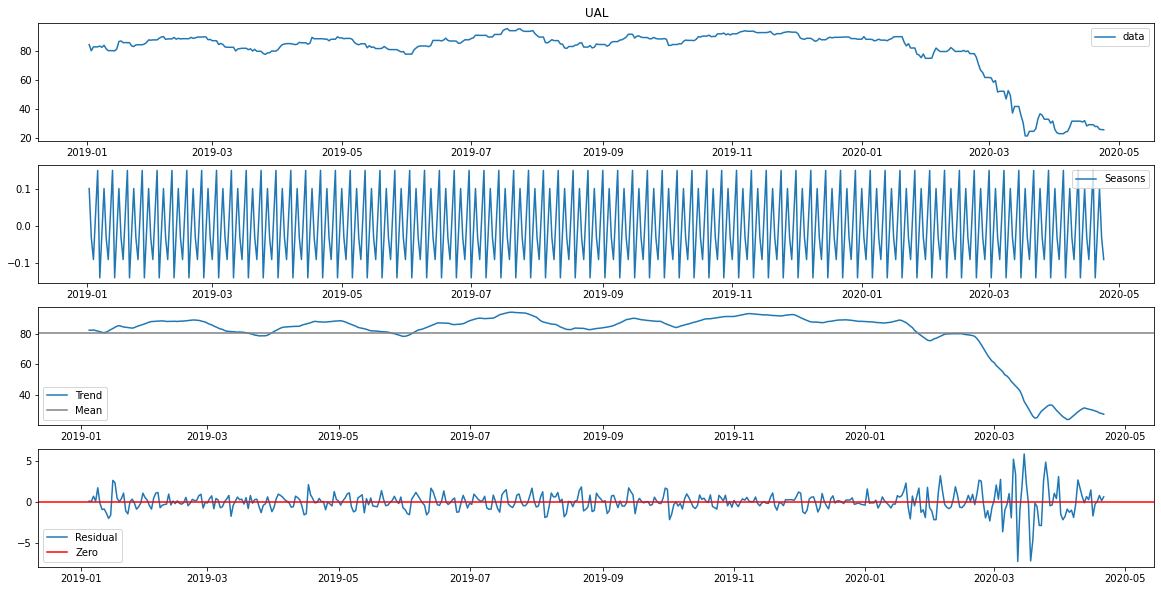

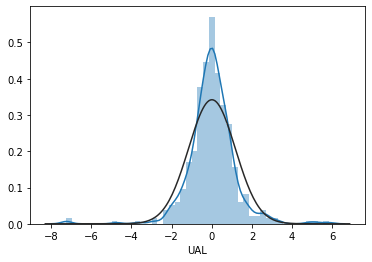

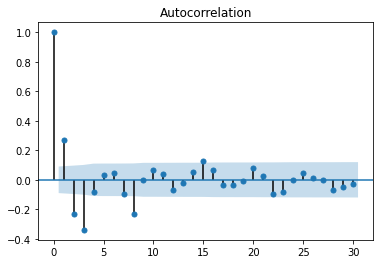

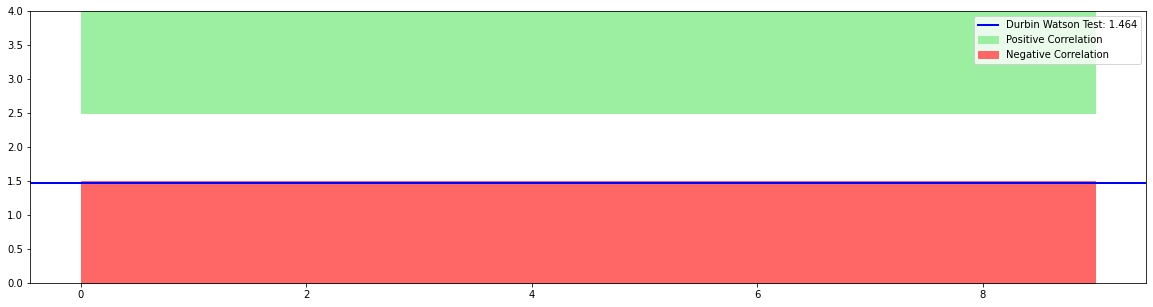

In [0]:
a = decompose(df_shares.UAL, start)

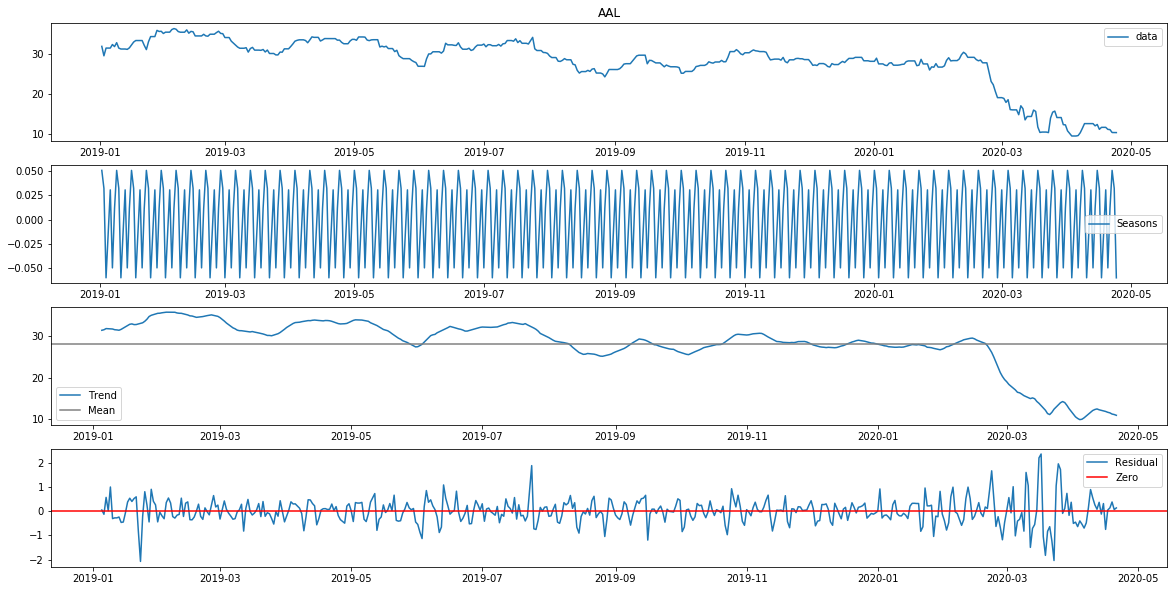

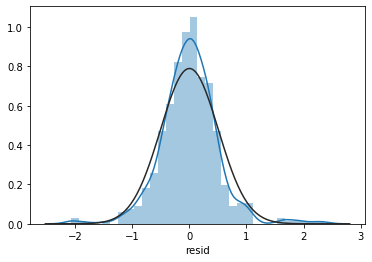

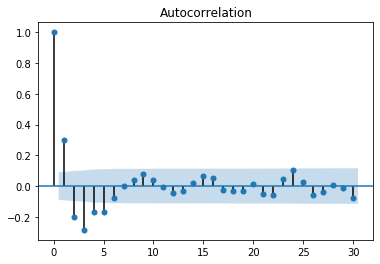

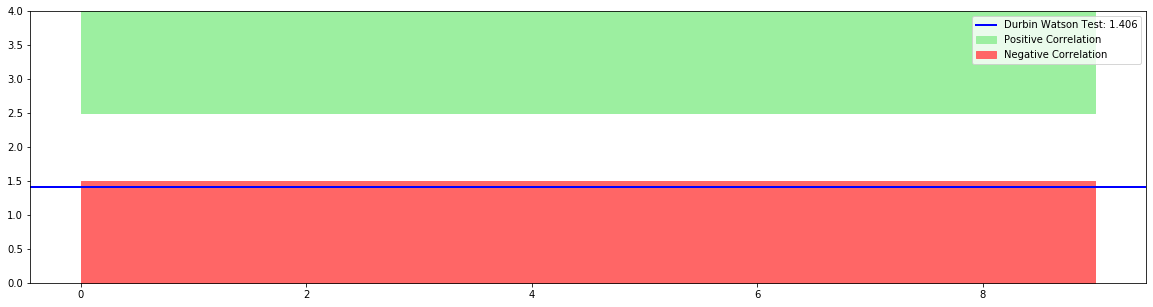

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7fb422eed940>,
 1.4064455311081148)

In [0]:
decompose(df_shares.AAL, start)

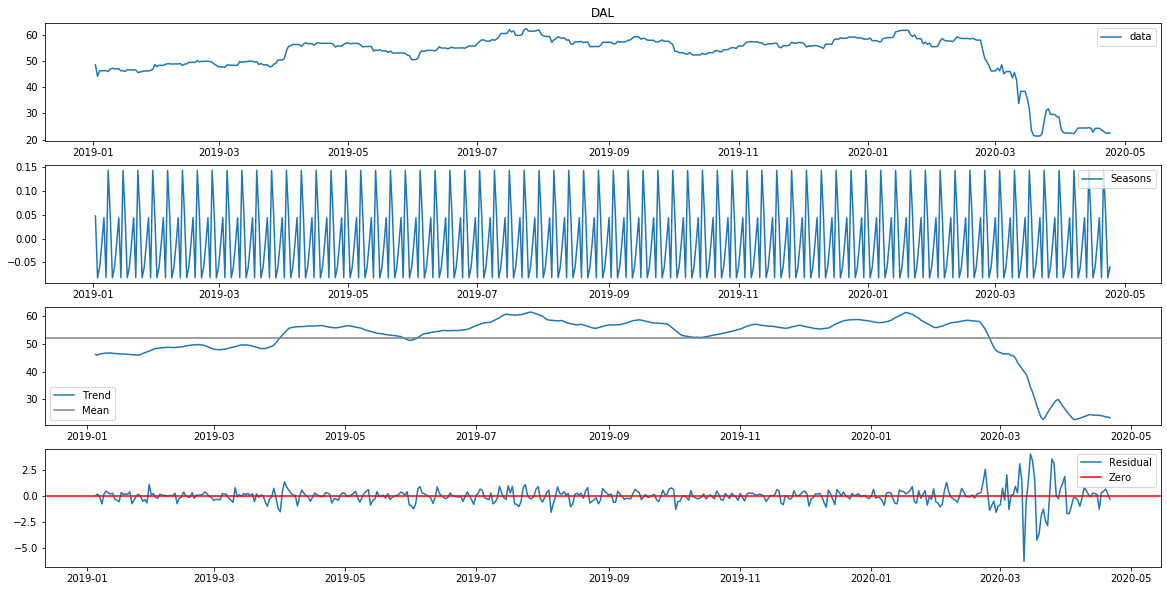

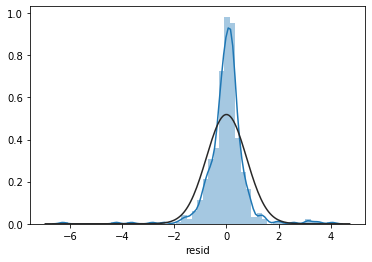

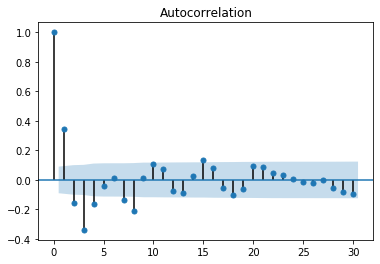

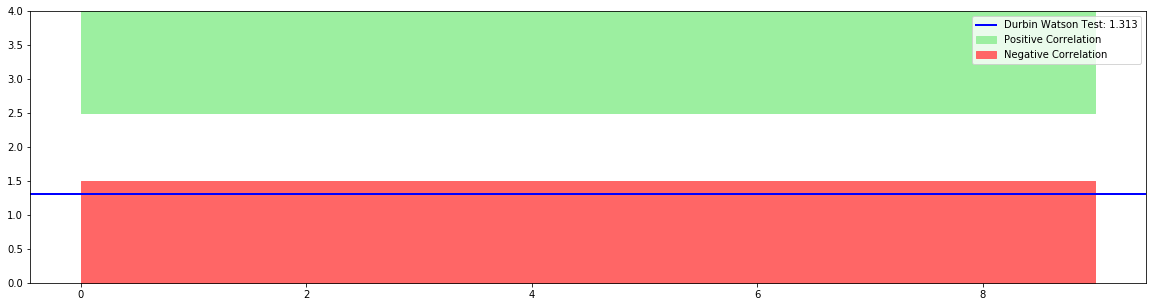

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7fb4295f9860>,
 1.3128621287731033)

In [0]:
decompose(df_shares.DAL, start)

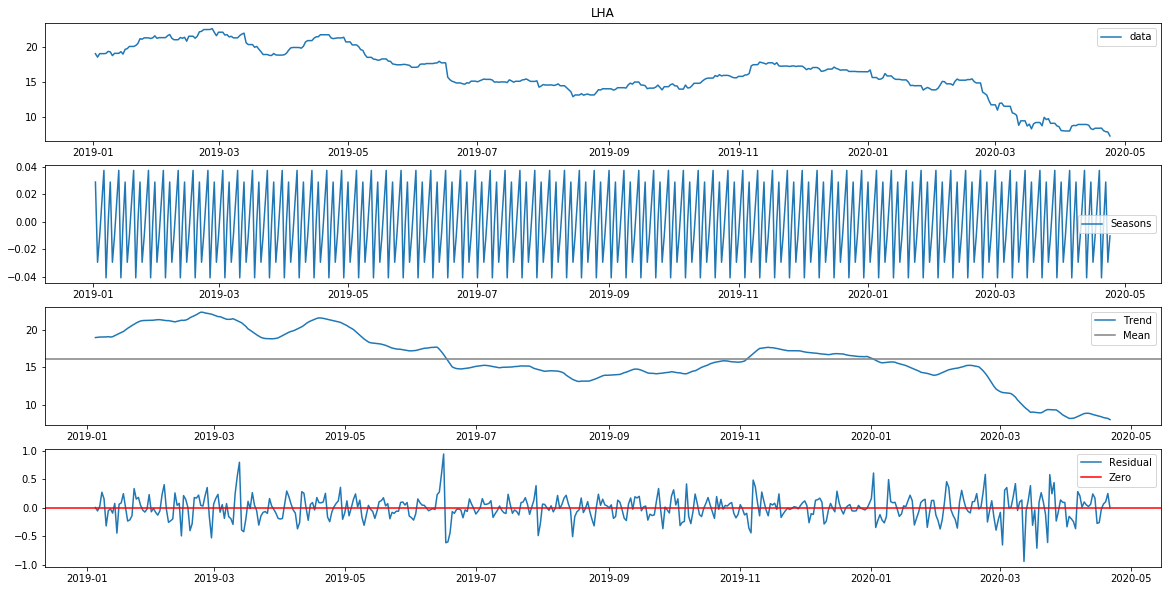

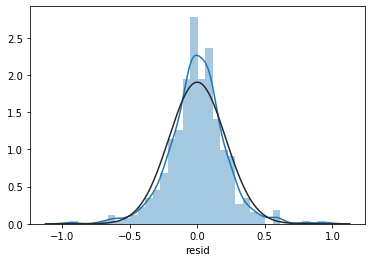

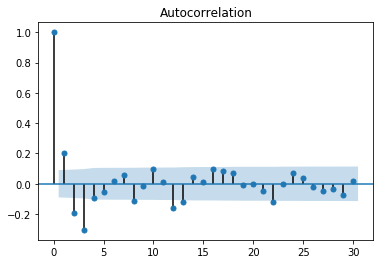

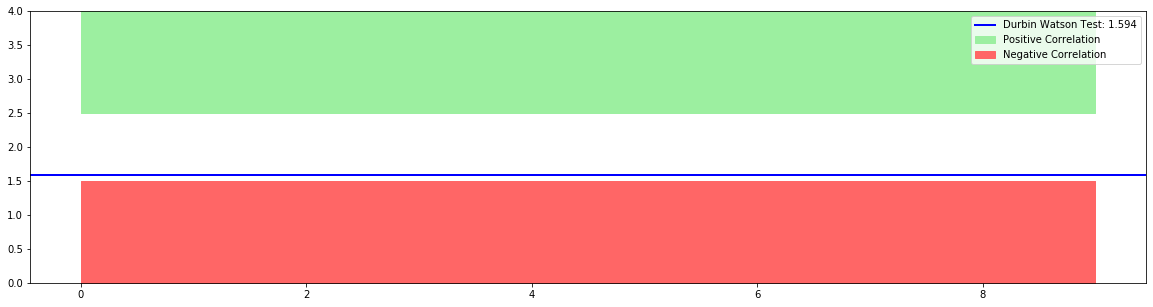

(<statsmodels.tsa.seasonal.DecomposeResult at 0x7fb42825a5f8>,
 1.5938064049039389)

In [0]:
decompose(df_shares.LHA, start)

# Pre-processing

## Functions

In [0]:
import tensorflow as tf
import random as rn

In [0]:
def reset_random_seeds(seed):
   #os.environ['PYTHONHASHSEED']=str(seed)
   tf.keras.backend.clear_session()
   np.random.seed(seed)
   rn.seed(seed)
   tf.random.set_seed(seed)

In [0]:
def windowed_dataset(series, params):
    
    window_size = params['window_size']
    batch_size = params['batch_size']
    shuffle_buffer = params['shuffle_buffer']
    seed = params['seed']

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer, seed=seed, reshuffle_each_iteration=False).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [0]:
def plot_train_valid(x_train, x_valid, offset=0):
    
    plt.figure(figsize=BIG)
    plt.xticks(rotation=45, fontsize=20)
    plt.plot(x_train.iloc[offset:], c='b', label='Train')
    plt.plot(x_valid, c='r', label='Valid')
    plt.legend(loc='best', fontsize=20)
    plt.grid()
    plt.show()
    
def plot_trends(trends, labels, colors=['green', 'blue', 'red'], x_line=None):
    
    plt.figure(figsize=BIG)
    plt.xticks(rotation=45, fontsize=20)
    
    for i in range(len(trends)):
        plt.plot(trends[i], c=colors[i], label=labels[i])

    if(x_line is not None):
      plt.axvline(x_line, linewidth=2, color='green')
        
    plt.legend(loc='best', fontsize=20)
    plt.grid()
    plt.show()

## Dataset

In [0]:
def generateDataset(params, series):

  n_forecast = params['n_forecast']

  x_train = series.iloc[:-n_forecast]
  x_valid = series.iloc[-n_forecast:]

  dataset = windowed_dataset(x_train.values, params)

  print('Training_set: {}'.format(x_train.shape))
  print('Validation_set: {}'.format(x_valid.shape))

  return x_train, x_valid, dataset

# Models

In [21]:
try:
  from skopt import gp_minimize
  from skopt.space import Real, Integer
  from skopt.utils import use_named_args
  from skopt.plots import plot_convergence
except:
  !pip install scikit-optimize
  from skopt import gp_minimize
  from skopt.space import Real, Integer
  from skopt.utils import use_named_args
  from skopt.plots import plot_convergence

     |████████████████████████████████| 81kB 2.7MB/s 


## Functions

In [0]:
def plot_loss(history, offset=0):
    loss = history.history['loss']
    
    plt.plot(loss[offset:], c='r')
    plt.show()
    
def forecast(model, x_train, x_valid, params, plot=True):
    
    window_size = params['window_size']
    split = params['split']
    
    forecast = []
    time_forecast = []
    
    timestamps = series.index
    
    for i in range(len(series) - window_size):
        
        prediction = model.predict(series.values[i:i + window_size][np.newaxis])
        
        time_forecast.append(timestamps[i+window_size])
        forecast.append(prediction)

    train_forecast = forecast[:split-window_size]    
    time_train = time_forecast[:split-window_size]
    
    valid_forecast = forecast[split-window_size:]
    time_valid = time_forecast[split-window_size:]

    train_results = np.array(train_forecast)[:, 0, 0]
    train_results = pd.Series(train_results, index=time_train)
    
    valid_results = np.array(valid_forecast)[:, 0, 0]
    valid_results = pd.Series(valid_results, index=time_valid)

    #plt.figure(figsize=(10, 6))
    #plot_train_valid(train_results, valid_results)
    
    trends = [series[window_size:], train_results, valid_results]
    labels = ['Real Trend', 'Train', 'Valid']
    colors = ['green', 'blue', 'red']

    if(plot):
      plot_trends(trends, labels, colors, x_line=valid_results.index[0])
    
    return train_results, valid_results

def real_forecast(model, x_train, x_valid, params, period=10, plot=True, offset=0):
  window_size = params['window_size']
  split = params['split']
  
  train_forecast = []
  time_forecast = []

  timestamps = x_train.index
  
  # Training Forecast
  for i in range(len(x_train) - window_size):
      
      prediction = model.predict(x_train.values[i:i + window_size][np.newaxis])
      
      date = timestamps[i+window_size] + timedelta(days=1)

      time_forecast.append(date)
      train_forecast.append(prediction)

  train_results = np.array(train_forecast)[:, 0, 0]
  train_results = pd.Series(train_results, index=time_forecast)
  
  # Testing Forecast
  series = x_train.copy()
  timestamps = list(series.index)

  test_forecast = []
  time_forecast = []

  for i in range(period):
      size = len(series)
      #print(series.values.shape)
      prediction = model.predict(series.values[size-window_size: ][np.newaxis])

      date = timestamps[-1] + timedelta(days=1)
      timestamps.append(date)

      series = series.append(pd.Series(prediction[0][0], index=[date]))

      time_forecast.append(date)
      test_forecast.append(prediction)

  test_results = np.array(test_forecast)[:, 0, 0]
  test_results = pd.Series(test_results, index=time_forecast)

  #plt.figure(figsize=(10, 6))
  #plot_train_valid(train_results, valid_results)
  
  trends = [series[window+offset:], train_results[offset:], x_valid, test_results]
  labels = ['Real Train', 'Pred_Train', 'Real test', 'Pred_Test']
  colors = ['green', 'blue', 'red', 'black']

  if(plot):
    print(len(trends))
    plot_trends(trends, labels, colors, x_line=x_valid.index[0])
  
  return train_results, test_results

def Linear_forecast(model, series, params):

  window_size = params['window_size']
  
  forecast = []
  
  for i in range(len(series) - window_size):
      
      prediction = model.predict(series.values[i:i + window_size][np.newaxis])
      
      forecast.append(prediction[0][0])

  return forecast  

def progressive_forecast(model, series, params, real=False):
  
  window_size = params['window_size']
  n_forecast = params['n_forecast']
  freq = params['freq']

  # SETTING FREQUENCY 
  freq_days = 1 if freq == 'D' else int(freq[0])
  print('Frequency: {}'.format(freq_days))
  series = series.asfreq(freq)

  time_index = []

  # TRAINING FORECAST
  if(real):
    train_forecast = Linear_forecast(model, series[:], params)
    time_index.extend(list(series[window:].index))
  else:
    train_forecast = Linear_forecast(model, series[:-n_forecast], params)
    time_index.extend(list(series[window:-n_forecast].index))
  
  
  # TEST_FORECAST
  test_forecast = pd.Series(train_forecast, index=time_index)
  forecast = list(test_forecast.values)
  #print(type(test_forecast))

  for i in range(n_forecast):
    
    pred = Linear_forecast(model, test_forecast[-window_size-1:], params)
    print(pred[0])
    forecast.append(pred[0])

    #print(len(time_index))
    #print(len(test_forecast))
    date = time_index[-1] + timedelta(days=freq_days)
    #print(date)
    time_index.append(date)

    test_forecast = pd.Series(forecast, index=time_index)
    #print(test_forecast)

  #print(test_forecast.shape)
  #print(len(time_index))
  test_forecast = pd.Series(test_forecast, index=time_index)
  #dispaly(test_forecast)

  return test_forecast[:-n_forecast], test_forecast[-n_forecast:]

def evaluate_model(series, prediction, params, train=False):
    window_size = params['window_size']
    
    if(train):
        true_series = series[window_size:]
    else:
        true_series = series
    
    return tf.keras.metrics.mean_absolute_error(true_series, prediction).numpy()

def evaluate(series, pred_series):
  return tf.keras.metrics.mean_absolute_error(series, pred_series).numpy()

def evaluate_prediction(true_series, pred_series):
    return tf.keras.metrics.mean_absolute_error(true_series, pred_series).numpy()

def performance_model(model, series, x_valid, params):
  pred_train, pred_valid = forecast(model, series, x_valid, params)

  train_error = evaluate_model(x_train, pred_train, params, train=True)
  valid_error = evaluate_model(x_valid, pred_valid, params)

  params['train_error'] = train_error
  params['valid_error'] = valid_error

  print('Train Error: {:.4f}'.format(train_error))
  print('Valid Error: {:.4f}'.format(valid_error))

  return pred_train, pred_valid

def evaluateResidual(series, prediction):

  residual = series - prediction

  plot_residual(residual)

  test_durbin_watson(residual)

  return residual

def plot_forecast(train_forecast, test_forecast, series, params, plot=True, offset=0, real=False):
  window_size = params['window_size']
  n_forecast = params['n_forecast']
  freq = params['freq']

  series = series.asfreq(freq)

  if(real):
    x_train = series[window_size:]

    trends = [x_train[offset:], train_forecast[offset:], test_forecast]
    labels = ['Train', 'Predicted_Train', 'Predicted_test']
    colors = ['b', 'r', 'r']

  else:
    x_train = series[window_size:-n_forecast]
    x_test = series[-n_forecast:]

    trends = [x_train[offset:], train_forecast[offset:], x_test, test_forecast]
    labels = ['Train', 'Predicted_Train', 'Test', 'Predicted_test']
    colors = ['b', 'r', 'b', 'r']

  if(plot):
    plot_trends(trends, labels, colors, x_line=test_forecast.index[0])

def save_model(params, folder, filename, save=True):
    
    param_dict = params
    param_dict['neurons'] = str(params['neurons'])
    param_dict['callbacks'] = str(params['callbacks'])
    param_dict['filters'] = str(params['filters'])

    df = pd.DataFrame(param_dict, index=[0])
    
    if(save):
        filepath = folder + params['model'] + '/'
        if(os.path.exists(filepath) == False):
            os.mkdir(filepath)
            
        full_path = filepath + filename
        i = 0
        while(os.path.exists(full_path)):
            full_path = full_path.split('.csv')[0] + str(i) +'.csv'
            i += 1
            
        df.to_csv(full_path)
    
    return df

## Linear Model

In [0]:
def LinearModel(dataset, params):
    
    neurons = params['neurons']
    window_size = params['window_size']
    loss = params['loss']
    lr = params['lr']
    opt = params['opt']
    callbacks = params['callbacks']
    epochs = params['epochs']
    verbose = params['verbose']
    seed = params['seed']

    reset_random_seeds(seed)
    
    assert len(neurons) >= 2, 'Too few layers'
    
    # Model Architecture
    lin_model = tf.keras.Sequential()
    
    for i in range(len(neurons)):
        
        if(i==0):
            lin_model.add(tf.keras.layers.Dense(neurons[i],
                                                input_shape=[window_size],
                                                activation='relu',
                                                kernel_initializer=tf.keras.initializers.he_normal(seed=seed)))
        
        else:
            lin_model.add(tf.keras.layers.Dense(neurons[i],
                                                activation='relu',
                                                kernel_initializer=tf.keras.initializers.he_normal(seed=seed),))
            
    # Model Fitting
    lin_model.compile(loss=loss, optimizer=opt(lr=lr), metrics=['mae'])
    hist = lin_model.fit(dataset, epochs=epochs, verbose=verbose, callbacks=callbacks)

    return lin_model, hist

### Params

In [0]:
ticker = 'UAL'
#ticker = 'DAL'
#ticker = 'AAL'
#ticker = 'LHA'

start = '2016-1-1'

series = df_shares[ticker][start:]

In [89]:
# ROLLING

rolling = 2
params['rolling'] = rolling

if(rolling != 0):
  series = series.rolling(rolling).mean().dropna()


# FREQUENCY

freq = 'D'
#freq = '3D'
params['freq']=freq
series.asfreq(freq=freq)

# FORECASTING

params['n_forecast'] = 10
test_size = 0
params['split'] = len(series) - test_size

x_train, x_valid, dataset = generateDataset(params, series)

# MODEL PARAMS
window = 100
params['window_size'] = window
params['batch_size'] = 32
dataset = windowed_dataset(x_train.values, params)

params['model'] = 'Linear'
params['neurons'] = [window,window//2,1]

params['opt'] = tf.keras.optimizers.Adam
params['lr'] = 1e-4
params['loss'] = tf.keras.losses.Huber()
params['callbacks'] = []
params['epochs'] = 500

params['verbose'] = 0
params['seed'] = 2020

Training_set: (1572,)
Validation_set: (10,)


### Model

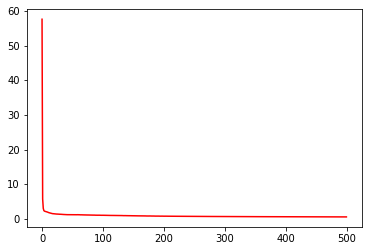

0.5517889261245728

In [90]:
lin_model, hist = LinearModel(dataset, params)
plot_loss(hist)
hist.history['loss'][-1]

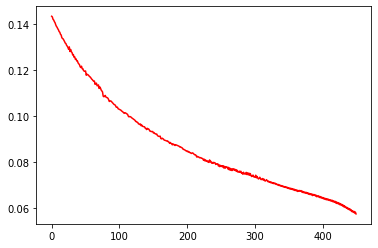

In [82]:
plot_loss(hist, offset=50)

In [0]:
#lin_model.summary()

### Progressive Forecast (on real data) 

In [93]:
params['n_forecast'] = 10
n_forecast = params['n_forecast']

train_for, test_for = progressive_forecast(lin_model, x_train, params, real=True)

Frequency: 1
25.39697
23.94403
23.938988
21.548841
19.707531
17.211735
15.5533495
16.301714
16.041298
14.526744


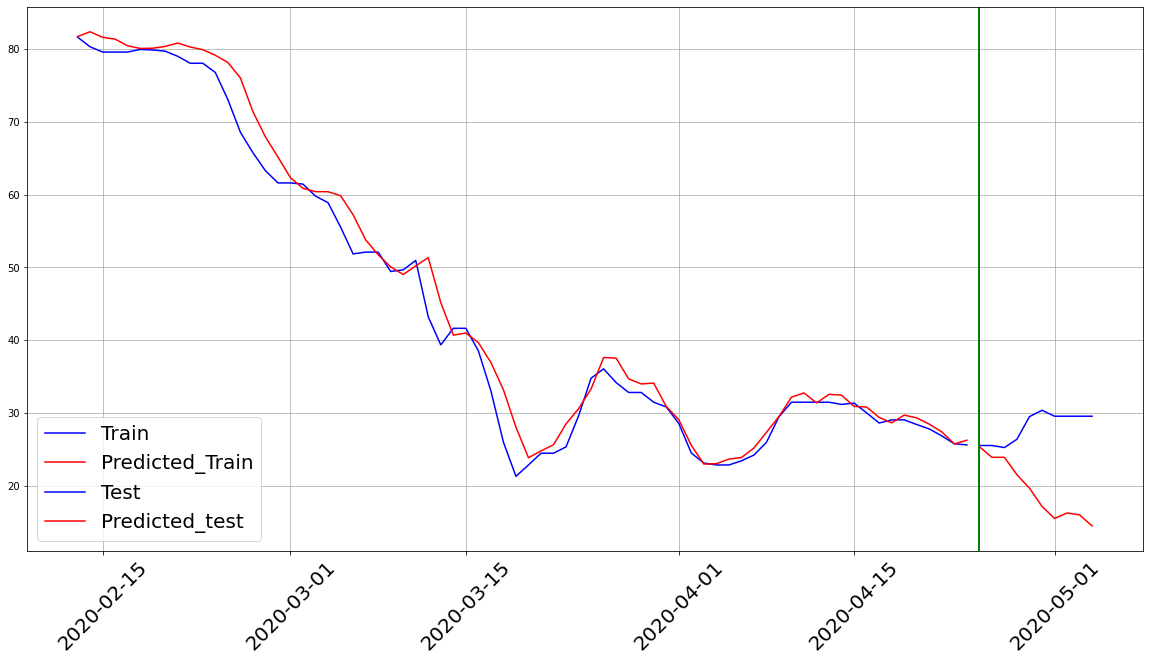

In [94]:
plot_forecast(train_for, test_for, series, params, offset=1400)

In [31]:
test_for.head()

2020-05-01    24.246626
2020-05-08    24.089155
2020-05-15    21.616308
2020-05-22    21.548655
2020-05-29    19.840862
dtype: float64

In [0]:
plot_forecast(train_for, test_for, series, params, offset=1400)

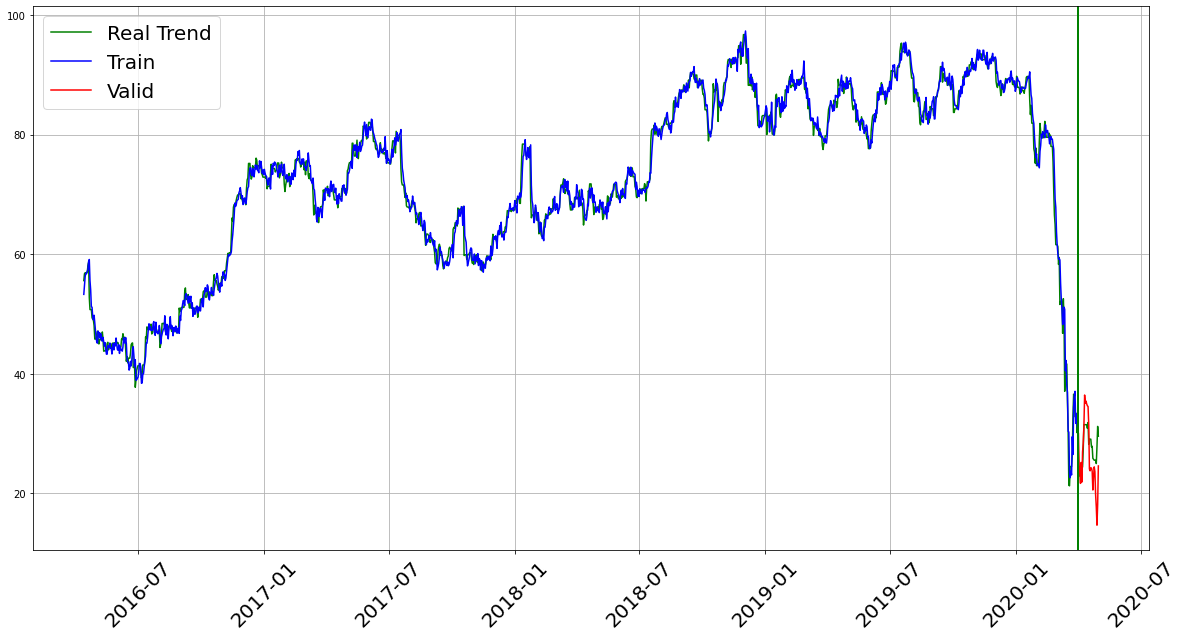

Train Error: 1.0721
Valid Error: 3.9695


In [0]:
  pred_train, pred_valid = performance_model(lin_model, series, x_valid, params)

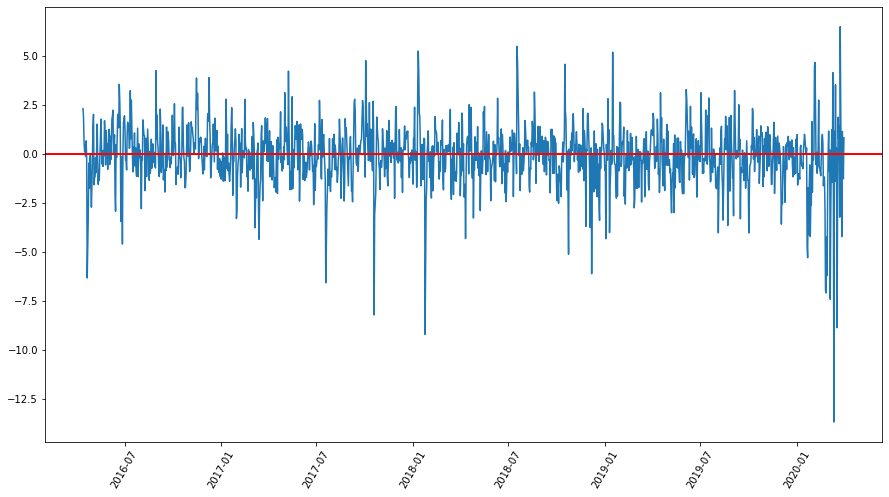

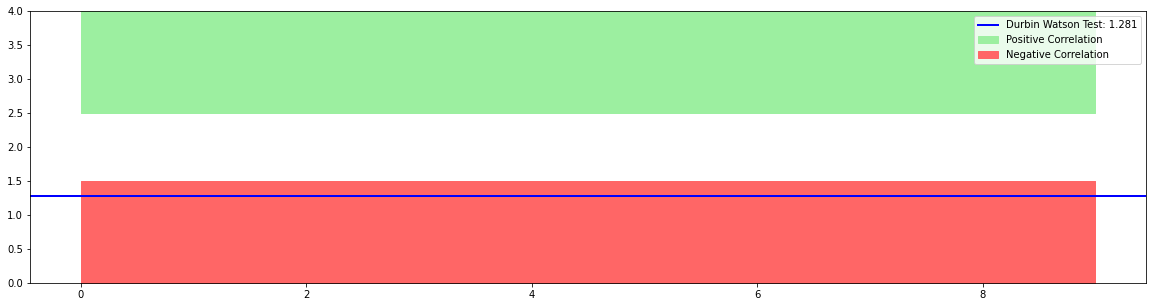

In [0]:
residual = evaluateResidual(x_train, pred_train)

### Progressive Forecast

4


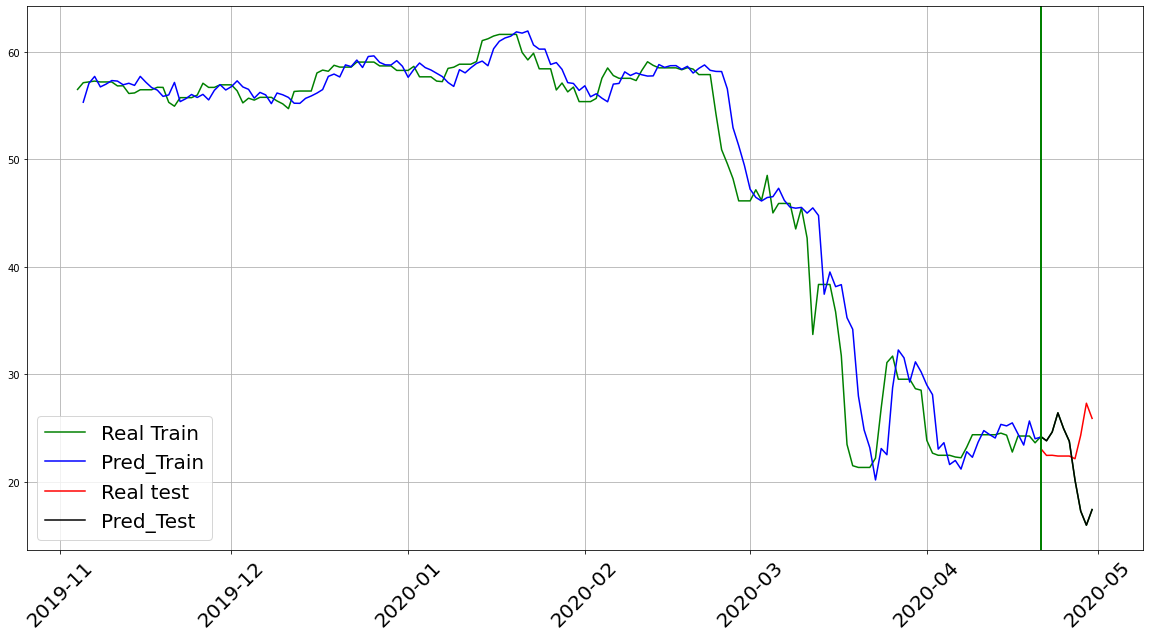

In [0]:
time_to_forecast = 10

pred_train, pred_real_test = real_forecast(lin_model, x_train, x_valid, params, time_to_forecast, offset=1300)

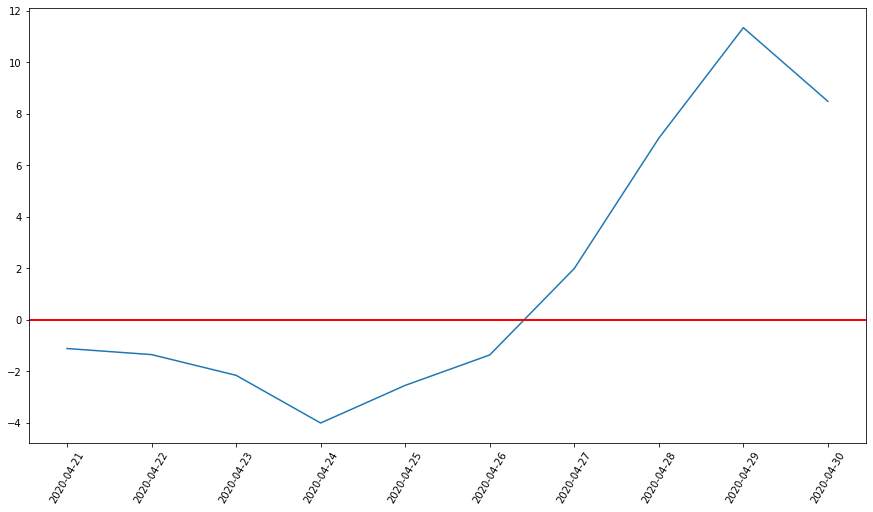

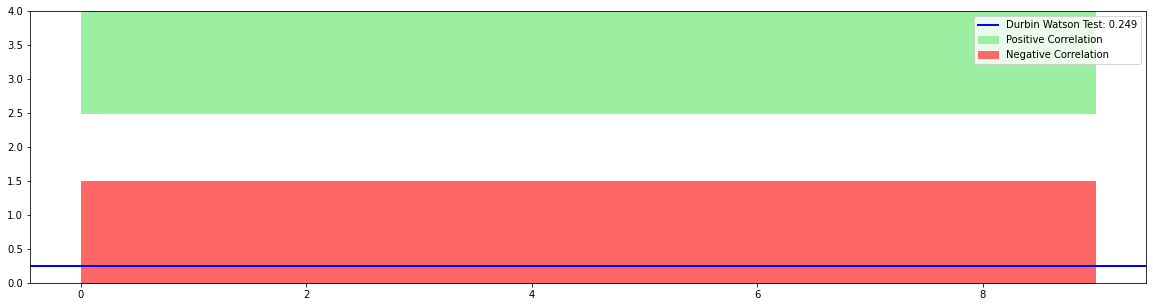

4.143092

In [0]:
residual = evaluateResidual(x_valid, pred_real_test)
evaluate_prediction(x_valid, pred_real_test)

In [0]:
params

### Saving 

In [0]:
filename = 'Linear_4'
folder = './'
save_model(params, folder, filename+'.csv')

,ticker,start,window_size,batch_size,shuffle_buffer,split,seed,rolling,freq,n_forecast,model,neurons,opt,lr,loss,callbacks,epochs,verbose,train_error,valid_error,filters,kernel
0,UAL,2016-1-1,100,32,230,1555,2020,0,D,10,Linear,"[100, 50, 1]",<class 'tensorflow.python.keras.optimizer_v2.a...,0.0001,<tensorflow.python.keras.losses.Huber object a...,[],500,0,0.607309,1.448542,"[64, 128, 128]",5


### Hyperoptimization

In [0]:
lr = Real(1e-5, 1e-2, name='lr')
n2 = Integer(10,30, name='n2')

dimensions = [lr, n2]

default_parameters = [1e-3, 10]

In [0]:
@use_named_args(dimensions=dimensions)
def fit_linear_model(lr, n2):
    
    neurons = params['neurons']
    window_size = params['window_size']
    loss = params['loss']
    opt = params['opt']
    epochs = params['epochs']
    verbose = params['verbose']
    seed = params['seed']

    reset_random_seeds(seed)

    assert len(neurons) >= 2, 'Too few layers'
    
    # Model Architecture
    lin_model = tf.keras.Sequential()
    
    for i in range(len(neurons)):
        
        if(i==0):
            lin_model.add(tf.keras.layers.Dense(window_size,
                                                input_shape=[window_size],
                                                activation='relu'))
        
        else:
            lin_model.add(tf.keras.layers.Dense(n2,
                                                activation='relu'))
            
    # Model Fitting
    lin_model.compile(loss=loss, optimizer=opt(lr=lr))
    hist = lin_model.fit(dataset, epochs=epochs, verbose=verbose)
    
    pred_train, pred_valid = forecast(lin_model, series, x_valid, params, plot=False)
    
    train_error = evaluate_model(x_train, pred_train, params, train=True)
    valid_error = evaluate_model(x_valid, pred_valid, params)
    
    return valid_error

In [0]:
search_result = gp_minimize(func=fit_linear_model,
                            dimensions=dimensions,
                            acq_func='EI',  # Expected Improvement.
                            n_calls=30,
                            x0=default_parameters,
                            random_state=params['seed'])


In [0]:
search_result.x

[0.0029070064222789503, 26]

In [0]:
[lr, n2] = search_result.x

In [0]:
params['lr']=lr
params['neurons'] = [window,n2,1]

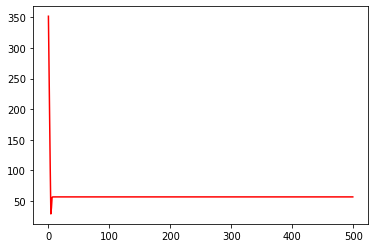

In [0]:
lin_model, hist  = LinearModel(dataset, params)
plot_loss(hist)

In [0]:
pred_train, pred_valid = performance_model(lin_model, series, x_valid, params)

### Hyperopt 2

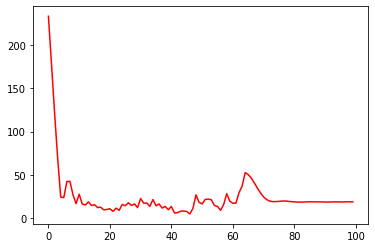

18.793004989624023

In [0]:
params['neurons'] = [30,10,1]
params['lr'] = 1e-3
params['epochs'] = 100
params['callbacks'] = tf.keras.callbacks.LearningRateScheduler(lambda epoch: params['lr'] * 10**(epoch / 20))

lin_model, hist = LinearModel(dataset, params)
plot_loss(hist)
hist.history['loss'][-1]

(0.001, 0.1, 0.0, 100.0)

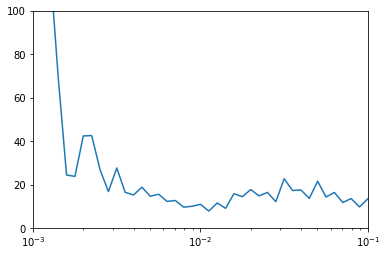

In [0]:
plt.semilogx(hist.history["lr"], hist.history["loss"])
plt.axis([params['lr'], 1e-1, 0, 100])

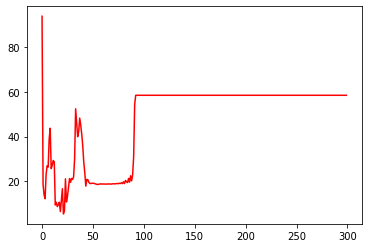

In [0]:
params['lr'] = 2e-2
params['epochs'] = 300
lin_model, hist = LinearModel(dataset, params)
plot_loss(hist)

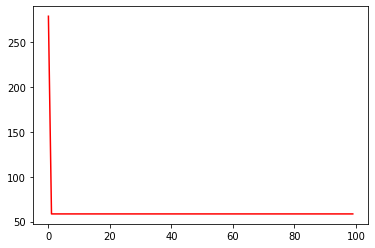

In [0]:
plot_loss(hist, 0)